In [1]:
pip install nlpaug numpy matplotlib python-dotenv

     |████████████████████████████████| 389kB 7.8MB/s 


In [2]:
pip install fairseq

     |████████████████████████████████| 1.7MB 8.2MB/s 
     |████████████████████████████████| 133kB 33.7MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 
     |████████████████████████████████| 112kB 29.4MB/s 
     |████████████████████████████████| 276kB 28.2MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-cp36-none-any.whl size=141231 sha256=f1cd4a508945849d02f8f7ef252a16dba4204db4b936df5c79c254601c07782f
  Stored in directory: /root/.cache/pip/wheels/e3/e2/fa/b78480b448b8579ddf393bebd3f47ee23aa84c89b6a78285c8
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=b1159ec09a32e1e0ecf609e86c551e569cfb481f6150ccbb66264771bd89dbe1
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built antlr4-python3-runtime PyYAML
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
pip install sacremoses

     |████████████████████████████████| 890kB 8.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=f60b6ac5fe6d365d6f713cfaa5e0eeef3de81e489d7b8d0b635d6f5989519a85
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
pip install fastBPE

  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp36-cp36m-linux_x86_64.whl size=481526 sha256=25632a51db94b932da682688e4a83796c8736d471a1673b86141da6406117961
  Stored in directory: /root/.cache/pip/wheels/f3/0c/9c/fc62058b4d473a5602bcd3d3edfece796f123875379ea82d79
Successfully built fastBPE


In [5]:
import pandas as pd
import numpy as np
import nltk
import spacy
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import  classification_report, confusion_matrix
from scipy import stats
import random
import nlpaug.augmenter.word as naw
from fairseq.models.transformer import TransformerModel
from sacremoses import MosesTokenizer, MosesDetokenizer
import fastBPE

%matplotlib inline
import seaborn as sns

sns.set()

# supress warnings (warnings do not prevent the code from executing)
import warnings

warnings.filterwarnings("ignore")

In [6]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [7]:
# check for gpu
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [8]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [9]:
tweets_df = pd.read_csv(r"/content/drive/MyDrive/Data/disaster_tweets.csv.zip (Unzipped Files)/tweets.csv")

tweets_df.info()

tweets_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11370 non-null  int64 
 1   keyword   11370 non-null  object
 2   location  7952 non-null   object
 3   text      11370 non-null  object
 4   target    11370 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 444.3+ KB


,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


## Data Cleaning

We will start by removing the redundant id column.

In [10]:
tweets_df2 = tweets_df.drop("id", axis=1)
tweets_df2.head()

,keyword,location,text,target
0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


In [11]:
tweets_df2.isnull().sum()

keyword        0
location    3418
text           0
target         0
dtype: int64

Since we are most interested in the text and targets columns for our analysis, we won't remove the rows with missing values in the location column because that would reduce our dataset by at least 30% and we only have over 11,000 data points as it is. The location column isn't relevent for our anaylsis anyway. In fact let's drop the column before continuing.

In [12]:
tweets_df3 = tweets_df2.drop("location", axis=1)
tweets_df3.head()

,keyword,text,target
0,ablaze,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,ablaze,Telangana: Section 144 has been imposed in Bha...,1
2,ablaze,Arsonist sets cars ablaze at dealership https:...,1
3,ablaze,Arsonist sets cars ablaze at dealership https:...,1
4,ablaze,"""Lord Jesus, your love brings freedom and pard...",0


In [13]:
def text_cleaner(text):
    # remove web links, special characters, and numbers
    text = re.sub(
        r"""(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+
        |(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))""",
        "",
        text,
    )
    # make alphanumeric
    text = re.sub("\w*\d\w*", " ", text)
    # lower case and remove punctuation
    text = re.sub("[%s]" % re.escape(string.punctuation), " ", text.lower())
    text = " ".join(text.split())
    return text


def column_cleaner(column):
    temp = []
    for c in column:
        cleaned = text_cleaner(c)
        temp.append(cleaned)

    column = temp
    return column

In [14]:
tweets_df4 = tweets_df3.copy()
tweets_df4["keyword"] = column_cleaner(tweets_df3["keyword"])
tweets_df4["text"] = column_cleaner(tweets_df3["text"])
tweets_df4.head()

,keyword,text,target
0,ablaze,communal violence in bhainsa telangana stones ...,1
1,ablaze,telangana section has been imposed in bhainsa ...,1
2,ablaze,arsonist sets cars ablaze at dealership,1
3,ablaze,arsonist sets cars ablaze at dealership,1
4,ablaze,lord jesus your love brings freedom and pardon...,0


## Exploratory Data Analysis

Let's first check our target variable and check for class balance.

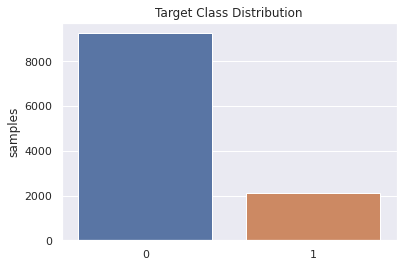

In [15]:
target_values = tweets_df4["target"].value_counts()
sns.barplot(target_values.index, target_values)
plt.gca().set_ylabel("samples")
plt.title("Target Class Distribution")
plt.show()

In [16]:
print(target_values)

0    9256
1    2114
Name: target, dtype: int64


Our 'real disaster' class is underrepresented, but it is only about a 1/5 ratio. We have some options in dealing with this problem. We could up-sample the minoirty class using SMOTE, but that will not work well with text data. We could down-sample the majority class, but our dataset is already small at just over 11,300 data points. Another option is to change our evalution metric to F1 score. This won't have us overweightting one highly accurate class. 

An option that could work is to augment our data. Data Augmentation is pretty common with NLP tasks. We will try this approach after we have tried without it. That way we have a compairison group and we will see which approach performs best. 

In [17]:
tweets_df4["keyword"].nunique()

208

In [18]:
keywords = pd.DataFrame(tweets_df4["keyword"].value_counts()).reset_index()
keywords.columns = ["keyword", "frequency"]
keywords.head(20)

,keyword,frequency
0,body,175
1,emergency,161
2,suicide,137
3,buildings,132
4,mass,131
5,nuclear,127
6,thunderstorm,93
7,flattened,88
8,fire,86
9,stretcher,86


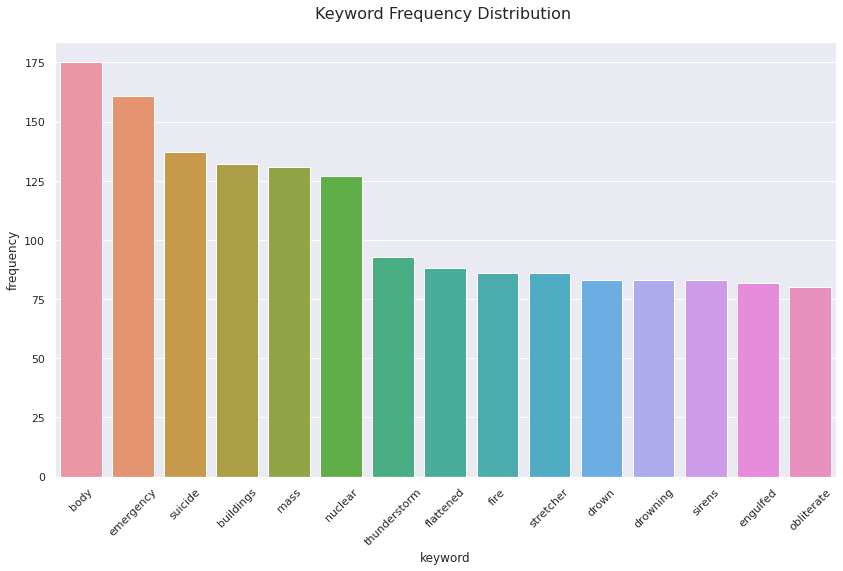

In [19]:
plt.figure(figsize=(14, 8))
sns.barplot(data=keywords.head(15), x="keyword", y="frequency")
plt.title("Keyword Frequency Distribution \n", fontsize=16)
plt.xticks(rotation=45)
plt.show()

In [20]:
def wordcloud(text, colormap="tab10", background_color="white"):
    cloud = WordCloud(
        width=1600,
        height=800,
        collocations=False,
        colormap=colormap,
        background_color=background_color,
    ).generate(" ".join(text))

    plt.figure(figsize=(12, 10))
    plt.imshow(cloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

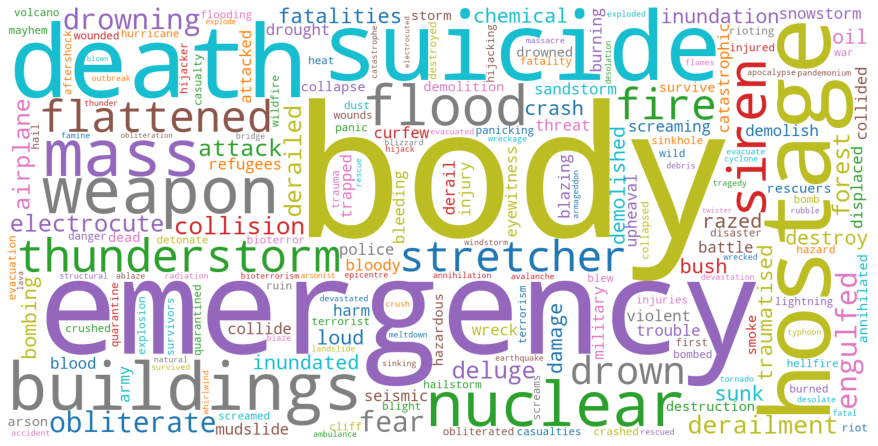

In [21]:
wordcloud(tweets_df4["keyword"])

## Feature Engineering

In [22]:
def preprocess(docs):
  lemmatizer = WordNetLemmatizer()
  preprocessed = []

  for doc in docs:
    tokenized = word_tokenize(doc)

    cleaned = [lemmatizer.lemmatize(token.lower())
              for token in tokenized
              if token.lower() not in stopwords.words('english')
              if token.isalpha()]
    
    untokenized = ' '.join(cleaned)

    preprocessed.append(untokenized)

  return preprocessed

In [23]:
# process words in text
preprocessed = preprocess(tweets_df4['text'])


In [24]:
preprocessed[:5]

['communal violence bhainsa telangana stone pelted muslim house house vehicle set',
 'telangana section imposed bhainsa january clash erupted two group january',
 'arsonist set car ablaze dealership',
 'arsonist set car ablaze dealership',
 'lord jesus love brings freedom pardon fill holy spirit set heart ablaze']

In [25]:
# define X and y
X = preprocessed
y = tweets_df4["target"]

# test/train split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
# logistic regression + tdidf
pipeline = Pipeline([('tdidf',TfidfVectorizer()),
                  ('logistic',LogisticRegression(class_weight = 'balanced'))
                  ])
parameters = {'logistic__C': stats.uniform(0.1, 100),
              'logistic__penalty': ['l1', 'l2'],
              'logistic__solver': ['lbfgs', 'liblinear']}

model = RandomizedSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1, n_iter=30 ,verbose=True)

model.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('tdidf',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                                       

In [27]:
#plot confustion matric helper function
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Given a scikit-learn confusion matrix (CM), make a nice plot.

    Arguments
    ---------
    cm:           Confusion matrix from sklearn.metrics.confusion_matrix

    target_names: Given classification classes, such as [0, 1, 2]
                  The class names, for example, ['high', 'medium', 'low']

    title:        The text to display at the top of the matrix

    cmap:         The gradient of the values displayed from matplotlib.pyplot.cm
                  See http://matplotlib.org/examples/color/colormaps_reference.html
                  `plt.get_cmap('jet')` or `plt.cm.Blues`

    normalize:    If `False`, plot the raw numbers
                  If `True`, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # Confusion matrix created by
                                                              # `sklearn.metrics.confusion_matrix`
                          normalize    = True,                # Show proportions
                          target_names = y_labels_vals,       # List of names of the classes
                          title        = best_estimator_name) # Title of graph

    Citation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [28]:
# function that displays a confusion matrix and classifcation report
def confusion_report(model, model_name):
  # define y test pred
  y_test_pred = model.predict(X_test)

  # plot model confusion matrix
  confusion = confusion_matrix(y_test, y_test_pred)
  plot_confusion_matrix(cm=confusion, 
                        target_names=['No Disaster','Disaster'],
                        title = f'{model_name.capitalize()} Model Disaster Tweets Confusion Matrix',
                        normalize=False)
  # model classifcation report
  print('\n')
  print('\n')
  print(f'---------------{model_name.capitalize()} Model Classification Report---------------')
  print(classification_report(y_test, y_test_pred))


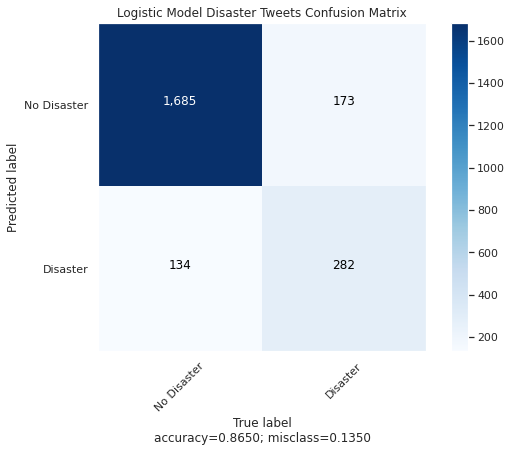





---------------Logistic Model Classification Report---------------
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1858
           1       0.62      0.68      0.65       416

    accuracy                           0.86      2274
   macro avg       0.77      0.79      0.78      2274
weighted avg       0.87      0.86      0.87      2274



In [29]:
# print confusion matrix and classification report
confusion_report(model, 'logistic')

In [30]:
# random forest + tdidf
pipeline = Pipeline([('tdidf',TfidfVectorizer()),
                  ('rfc',RandomForestClassifier(class_weight = 'balanced'))
                  ])
parameters = {'rfc__n_estimators': stats.randint(4,200),
              'rfc__max_depth': stats.randint(5, 30),
              'rfc__min_samples_split': stats.randint(2, 20),
              'rfc__min_samples_leaf': stats.randint(2, 20)}

model = RandomizedSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1, n_iter=30 ,verbose=True)

model.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   51.9s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('tdidf',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                                       

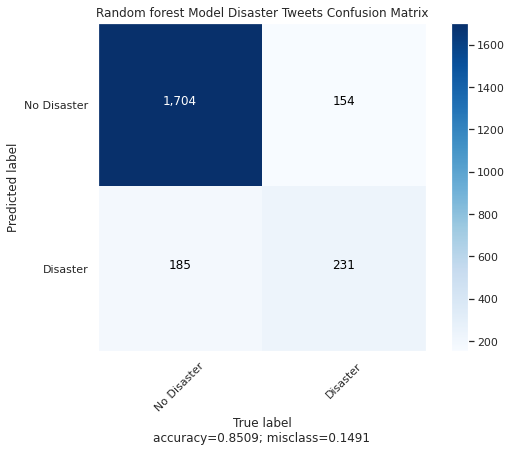





---------------Random forest Model Classification Report---------------
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1858
           1       0.60      0.56      0.58       416

    accuracy                           0.85      2274
   macro avg       0.75      0.74      0.74      2274
weighted avg       0.85      0.85      0.85      2274



In [31]:
# print confusion matrix and classification report
confusion_report(model, 'random forest')

In [32]:
# test naw text converter
text = 'The quick brown fox jumped over the lazy dog'
back_translation_aug = naw.BackTranslationAug(
    from_model_name='transformer.wmt19.en-de',
    to_model_name='transformer.wmt19.de-en')
back_translation_aug.augment(text)

Downloading: "https://github.com/pytorch/fairseq/archive/master.zip" to /root/.cache/torch/hub/master.zip
100%|██████████| 11946275315/11946275315 [04:28<00:00, 44410454.83B/s]
Using cache found in /root/.cache/torch/hub/pytorch_fairseq_master
100%|██████████| 11958904958/11958904958 [04:29<00:00, 44348793.01B/s]


OSError: ignored

In [ ]:
non_disaster_count = twitter_df4['target'].count(0)[0]
disaster_count = twitter_df4['target'].count(0)[1]

In [ ]:
# create df where target = 1
disaster_df = twitter_df4.loc[twitter_df4['target'] == 1]
disaster_df['target'].value_counts()

In [ ]:

def aug_text(df,text_column,stop_num):
  # list for newly augmented data
  aug_data = []
  while len(aug_data) <= stop_num:
    for row in df:
      sample = df.sample()
      for text in sample[text_column]:
        # generate list of tuples of language translation from lang & back to eng
        language = [('transformer.wmt19.en-de','transformer.wmt19.de-en'),
                    ('transformer.wmt19.en-ru','transformer.wmt19.ru-en'),
                    ('transformer.wmt15.en-fr','transformer.wmt15.fr-en'),
                    ('transformer.wmt19.en-cs','transformer.wmt19.cs-en'),
                    ('transformer.wmt19.en-zh','transformer.wmt19.zh-en')]
        sr = random.SystemRandom(language)
        back_translation_aug = naw.BackTranslationAug(
        from_model_name=f'{sr[0]}',
        to_model_name=f'{sr[1]}')
        aug_data.append(back_translation_aug.augment(text))
  return aug_data

In [ ]:
bt = aug_text(disaster,'text',stop_num=non_disater_count-disaster_count)

In [ ]:
# process words in text
preprocessed = preprocess(tweets_df4['text'])

In [ ]:
preprocessed[:5]

In [ ]:
# define X and y
X = preprocessed
y = bt["target"]

# test/train split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# back translate logistic regression + tdidf
pipeline = Pipeline([('tdidf',TfidfVectorizer()),
                  ('logistic',LogisticRegression(class_weight = 'balanced'))
                  ])
parameters = {'logistic__C': stats.uniform(0.1, 100),
              'logistic__penalty': ['l1', 'l2'],
              'logistic__solver': ['lbfgs', 'liblinear']}

model = RandomizedSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1, n_iter=30 ,verbose=True)

model.fit(X_train, y_train)

In [ ]:
# print confusion matrix and classification report
confusion_report(model, 'logistic')

In [ ]:
# back translate random forest + tdidf
pipeline = Pipeline([('tdidf',TfidfVectorizer()),
                  ('rfc',RandomForestClassifier(class_weight = 'balanced'))
                  ])
parameters = {'rfc__n_estimators': stats.randint(4,200),
              'rfc__max_depth': stats.randint(5, 30),
              'rfc__min_samples_split': stats.randint(2, 20),
              'rfc__min_samples_leaf': stats.randint(2, 20)}

model = RandomizedSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1, n_iter=30 ,verbose=True)

model.fit(X_train, y_train)

In [ ]:
# print confusion matrix and classification report
confusion_report(model, 'random forest')